In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
np.random.seed(0)

In [22]:
df = pd.read_csv("./../out.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [23]:
df = df.loc[400:1400] # first 1000 segments
df

,segment,label
400,obstin bigot offici set defianc liber initi go...,c
401,ask thing and proper repli must given It said ...,c
402,co-oper attempt dethron but influenc act parli...,c
403,busi necessari parliament elect execut cours f...,c
404,behind treasuri bench nay possibl rise man sit...,c
...,...,...
1395,lamb chop fri tomato potato la crãªme rais bis...,g
1396,glass rhine wine IV glass water V glass champa...,g
1397,cover cloth set away cool place hour dinner ti...,g
1398,transpar veil egg cook white firm lift griddl ...,g


In [24]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vec = TfidfVectorizer()
tfidf = tfidf_vec.fit_transform(df['segment'])

In [25]:
tfidf

<1000x9052 sparse matrix of type '<class 'numpy.float64'>'
	with 109944 stored elements in Compressed Sparse Row format>

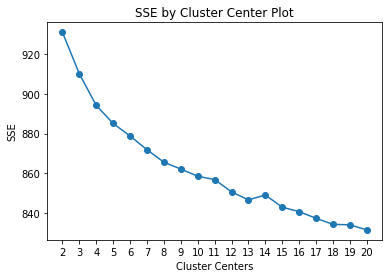

In [26]:
def elbow_method(data, K):
    iters = range(2, K + 1)
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters = k, 
                        init='k-means++', 
                        max_iter=300, 
                        n_init=10, 
                        random_state=0)
                        .fit(data)
                        .inertia_)

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

elbow_method(tfidf, 20)
# Elbow occurs at k=12

In [27]:
from sklearn.metrics import cohen_kappa_score, adjusted_rand_score, silhouette_score
def silhouette_method(data, K):
    iters = range(2, K + 1)
    score = []
    for k in iters:
        model = KMeans(n_clusters = k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        cluster_labels = model.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters =" + str(k) + "The average silhouette_score is :" + str(silhouette_avg))

# silhouette_method(tfidf, 20)
# silhouette score at k = 5 reach maximium

In [28]:
k = 5
tfidf_kmeans = KMeans(n_clusters = k, init='k-means++', max_iter=300, n_init=10, random_state=0)
tfidf_kmeans_pred = tfidf_kmeans.fit_predict(tfidf)
# https://stackoverflow.com/questions/60293351/how-tfidf-value-is-used-in-k-means-clustering

In [29]:
# dimension reduction--visualization
from sklearn.manifold import TSNE
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.decomposition import TruncatedSVD
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

tfidf_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(tfidf)

In [42]:
tfidf

<1x9052 sparse matrix of type '<class 'numpy.float64'>'
	with 122 stored elements in Compressed Sparse Row format>

In [30]:
tfidf_embedded = TSNE(n_components=2, 
                    perplexity=50, 
                    init='pca', # globally more stable to initialization
                    learning_rate = 'auto',
                    n_iter=1000, 
                    random_state=0).fit_transform(tfidf_reduced)

C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


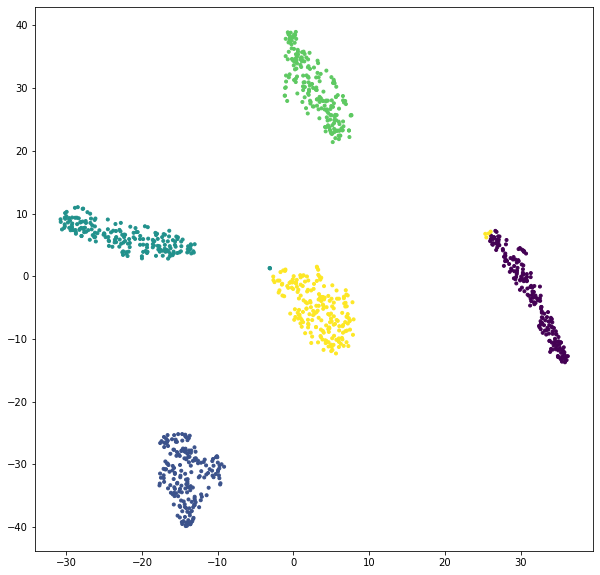

In [31]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = tfidf_kmeans.labels_)
plt.show()

In [32]:
"""
map model labels to actual labels
"""
pred_map = dict()
for i in range(0, 5):
    a = tfidf_vec.transform(df['segment'][i * 200 : i * 200 + 200])
    count = np.bincount(tfidf_kmeans.predict(a))
    np.ndarray.resize(count, (1,k))
    count = count[0]
    index = np.where(count == max(count))[0][0]
    label = chr(ord('a')+i)
    pred_map[index] = label
    print(label + ":" + np.array2string(count) + "\t" + label + " mapped to " + str(index))

mapped_pred = []
for ele in tfidf_kmeans_pred:
    mapped_pred.append(pred_map[ele])
mapped_pred = np.asarray(mapped_pred) # predicted label

a:[  0   0 198   0   2]	a mapped to 2
b:[  0   0   0   0 200]	b mapped to 4
c:[  0   0   0 200   0]	c mapped to 3
d:[  0 197   3   0   0]	d mapped to 1
e:[196   0   0   0   4]	e mapped to 0


In [33]:
from sklearn.metrics import cohen_kappa_score, adjusted_rand_score, silhouette_score
print("kappa: " + str(cohen_kappa_score(df['label'], mapped_pred)))
print("rand score: " + str(adjusted_rand_score(df['label'], mapped_pred)))
print("silhouette score: " + str(silhouette_score(tfidf, tfidf_kmeans_pred, random_state = 0)))

kappa: -0.1345586566825503
rand score: 0.9775815997312526
silhouette score: 0.04034408061394168


TODO: Coherence and Kappa for K > num features